<a href="https://colab.research.google.com/github/SaiMani-Ritish/Machine-Learning-in-English-Accent-Detection/blob/main/English_Accent_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we are loading the dataset using the kagglehub method.

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# 1. Download Data
print("Downloading Dataset...")
path = kagglehub.dataset_download("rtatman/speech-accent-archive")
DATA_PATH = os.path.join(path, "recordings", "recordings")
CSV_PATH = os.path.join(path, "speakers_all.csv")

# 2. Filter Data (Top Accents + Italian)
TARGET_ACCENTS = ['english', 'spanish', 'arabic', 'mandarin', 'french', 'italian']
df = pd.read_csv(CSV_PATH)
df = df[df['native_language'].isin(TARGET_ACCENTS)]

# Quick check to remove missing files
valid_rows = []
for idx, row in df.iterrows():
    if os.path.exists(os.path.join(DATA_PATH, row['filename'] + '.mp3')):
        valid_rows.append(row)
df = pd.DataFrame(valid_rows)

print(f"Dataset Ready: {len(df)} samples.")

Using Colab cache for faster access to the 'speech-accent-archive' dataset.
Dataset Ready: 1004 samples.


### BASELINE (MFCC + SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def extract_baseline_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=5.0)
        # Extract MFCCs (Fundamental characteristics)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        # Aggregate: Take Mean and Std Dev to get a single vector per clip
        mfcc_mean = np.mean(mfcc.T, axis=0)
        mfcc_std = np.std(mfcc.T, axis=0)
        return np.hstack([mfcc_mean, mfcc_std])
    except:
        return None

print("Step 1: Extracting MFCCs for Baseline...")
X_mfcc = []
y_mfcc = []

for idx, row in df.iterrows():
    feat = extract_baseline_features(os.path.join(DATA_PATH, row['filename'] + '.mp3'))
    if feat is not None:
        X_mfcc.append(feat)
        y_mfcc.append(row['native_language'])

# Train SVM
X_train, X_test, y_train, y_test = train_test_split(X_mfcc, y_mfcc, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)
baseline_acc = accuracy_score(y_test, svm_model.predict(X_test_scaled))

print(f"RESULT")
print(f"Baseline SVM Accuracy: {baseline_acc*100:.2f}%")

Step 1: Extracting MFCCs for Baseline...
RESULT
Baseline SVM Accuracy: 59.70%


SPECTROGRAMS + CNN + AUGMENTATION

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Augmentation Function
def augment_audio(y, sr):
    # Add Noise
    noise_amp = 0.005 * np.random.uniform() * np.amax(y)
    y = y + noise_amp * np.random.normal(size=y.shape[0])
    # Pitch Shift (Simple approximation)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))

# 2. Feature Extraction (Spectrograms)
def extract_spectrogram(file_path, augment=False):
    y, sr = librosa.load(file_path, duration=5.0)
    if len(y) < 5*sr: y = np.pad(y, (0, 5*sr - len(y)))
    else: y = y[:5*sr]

    if augment:
        y = augment_audio(y, sr)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    return librosa.power_to_db(mel)[..., np.newaxis] # Add channel dim

print("Step 2: Processing Spectrograms (with Augmentation)...")
X_spec, y_spec = [], []

# We create copies to increase dataset size (Augmentation)
for idx, row in df.iterrows():
    path = os.path.join(DATA_PATH, row['filename'] + '.mp3')
    # Original
    X_spec.append(extract_spectrogram(path, augment=False))
    y_spec.append(row['native_language'])
    # Augmented Version
    X_spec.append(extract_spectrogram(path, augment=True))
    y_spec.append(row['native_language'])

X_spec = np.array(X_spec)
encoder = LabelEncoder()
y_spec_enc = encoder.fit_transform(y_spec)

# 3. CNN Model
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_spec, y_spec_enc, test_size=0.2)

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train_s.shape[1:]),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(TARGET_ACCENTS), activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training CNN...")
model_cnn.fit(X_train_s, y_train_s, epochs=10, batch_size=32, verbose=0)
loss, cnn_acc = model_cnn.evaluate(X_test_s, y_test_s, verbose=0)

print(f"RESULT")
print(f"CNN Accuracy: {cnn_acc*100:.2f}%")

Step 2: Processing Spectrograms (with Augmentation)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN...
RESULT
CNN Accuracy: 85.82%


TRANSFER LEARNING (Embeddings)

In [ ]:
import tensorflow_hub as hub

# Load Pretrained Model (YAMNet)
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

def extract_embeddings(file_path):
    y, sr = librosa.load(file_path, sr=16000) # YAMNet needs 16k
    scores, embeddings, spectrogram = yamnet(y)
    return tf.reduce_mean(embeddings, axis=0).numpy() # Average embedding

print("Step 3: Extracting Embeddings (Transfer Learning)...")
X_emb, y_emb = [], []
for idx, row in df.iterrows():
    try:
        emb = extract_embeddings(os.path.join(DATA_PATH, row['filename'] + '.mp3'))
        X_emb.append(emb)
        y_emb.append(row['native_language'])
    except: pass

X_emb = np.array(X_emb)
y_emb_enc = encoder.fit_transform(y_emb) # Re-use encoder
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_emb, y_emb_enc, test_size=0.2)

# Small Classifier (as requested)
model_tl = Sequential([
    Dense(256, activation='relu', input_shape=(1024,)), # YAMNet outputs 1024 dim
    Dropout(0.3),
    Dense(len(TARGET_ACCENTS), activation='softmax')
])
model_tl.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_tl.fit(X_train_e, y_train_e, epochs=20, verbose=0)
loss, tl_acc = model_tl.evaluate(X_test_e, y_test_e, verbose=0)

print(f"RESULT (FINAL)")
print(f"Transfer Learning Accuracy: {tl_acc*100:.2f}%")

Step 3: Extracting Embeddings (Transfer Learning)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


RESULT (FINAL)
Transfer Learning Accuracy: 64.68%


PERFORMANCE VISUALIZATION

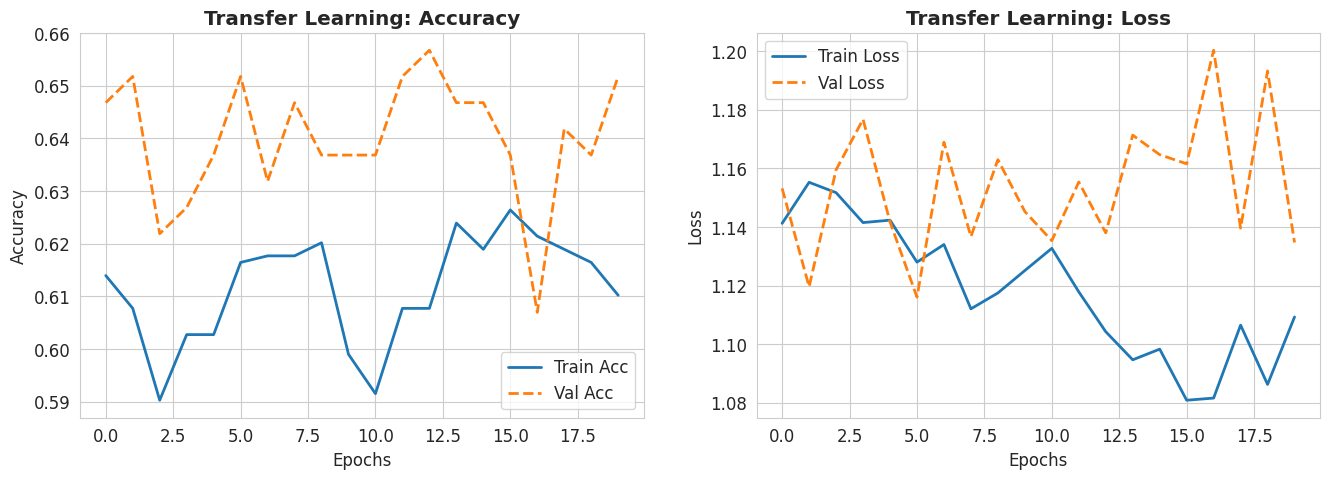

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


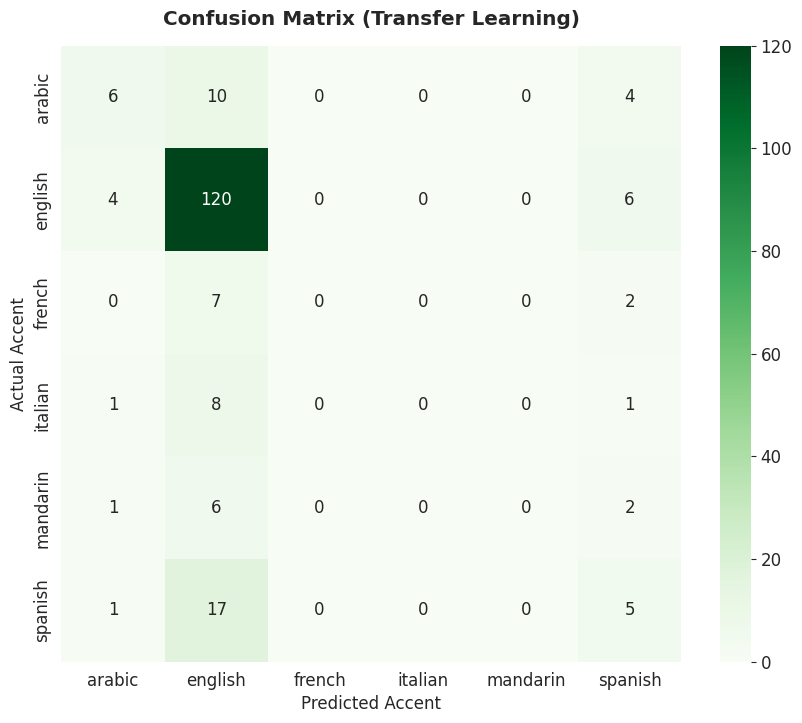

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


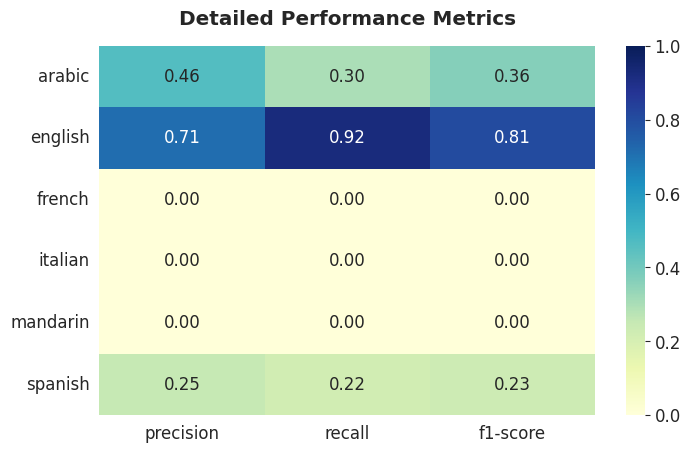

In [ ]:
# Style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_transfer_learning_results(model, history, X_test, y_test, classes):
    # 1. ACCURACY & LOSS CURVES
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    try:
        axes[0].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2, linestyle='--')
    except: pass
    axes[0].set_title('Transfer Learning: Accuracy', fontweight='bold')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    try:
        axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--')
    except: pass
    axes[1].set_title('Transfer Learning: Loss', fontweight='bold')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    plt.show()

    # --- FIX STARTS HERE ---
    # 2. PREPARE PREDICTIONS
    # Get model predictions (probabilities)
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # specific fix: Check if y_test is 1D (integers) or 2D (one-hot)
    if y_test.ndim == 1:
        y_true = y_test
    else:
        y_true = np.argmax(y_test, axis=1)

    # --- FIX ENDS HERE ---

    # 3. CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (Transfer Learning)', fontweight='bold', pad=15)
    plt.ylabel('Actual Accent')
    plt.xlabel('Predicted Accent')
    plt.show()

    # 4. CLASSIFICATION REPORT HEATMAP
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df_report = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

    plt.figure(figsize=(8, len(classes)*0.8))
    sns.heatmap(df_report[['precision', 'recall', 'f1-score']],
                annot=True, cmap='YlGnBu', fmt='.2f', vmin=0, vmax=1)
    plt.title('Detailed Performance Metrics', fontweight='bold', pad=15)
    plt.show()

# Run the fixed function
plot_transfer_learning_results(
    model=model_tl,
    history=history,
    X_test=X_test_e,
    y_test=y_test_e,
    classes=encoder.classes_
)